# Курсовая работа Королева И. ПМ18-3 

# Тема - Разработка системы сбора и структурирования данных о номенклатуре определенной группы интернет-магазина

In [3]:
import requests
import bs4
from lxml import html
import logging
import collections
import re
import json
import math
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# 1. Парсинг данных с интернет-магазина "Всё для крохи"

In [2]:
req = requests.get('https://www.vsekroham.ru/')
tree = html.fromstring(req.content)
links = [i for i in tree.xpath('//a/@href') if i.startswith('/catalog/') and len(i.split('/')) != 4 and '%' not in i]
correct_links = []
for item in links:
    cnt = 0
    for other in links:
        if item in other:
            cnt += 1
    if cnt == 1:
        correct_links.append(item)
correct_links = ['https://www.vsekroham.ru' + i for i in correct_links]
#print(correct_links)
inside_links = []
for link in correct_links:
    inside_links.append(link + '?pageSize=60')
    req = requests.get(link + '?pageSize=60')
    tree = html.fromstring(req.content)
    max_num = math.ceil(int(tree.xpath('//span[@class="sortby__result"]/span//text()')[0])/60)
    for i in range(2, max_num + 1):
        inside_links.append(link + f'page-{i}/?pageSize=60')
inside_links

['https://www.vsekroham.ru/catalog/kolyaski/kolyaski-lulki/?pageSize=60',
 'https://www.vsekroham.ru/catalog/kolyaski/kolyaski-lulki/page-2/?pageSize=60',
 'https://www.vsekroham.ru/catalog/kolyaski/kolyaski-lulki/page-3/?pageSize=60',
 'https://www.vsekroham.ru/catalog/kolyaski/kolyaski-2-v-1/?pageSize=60',
 'https://www.vsekroham.ru/catalog/kolyaski/kolyaski-2-v-1/page-2/?pageSize=60',
 'https://www.vsekroham.ru/catalog/kolyaski/kolyaski-2-v-1/page-3/?pageSize=60',
 'https://www.vsekroham.ru/catalog/kolyaski/kolyaski-2-v-1/page-4/?pageSize=60',
 'https://www.vsekroham.ru/catalog/kolyaski/kolyaski-2-v-1/page-5/?pageSize=60',
 'https://www.vsekroham.ru/catalog/kolyaski/kolyaski-2-v-1/page-6/?pageSize=60',
 'https://www.vsekroham.ru/catalog/kolyaski/kolyaski-2-v-1/page-7/?pageSize=60',
 'https://www.vsekroham.ru/catalog/kolyaski/kolyaski-2-v-1/page-8/?pageSize=60',
 'https://www.vsekroham.ru/catalog/kolyaski/kolyaski-2-v-1/page-9/?pageSize=60',
 'https://www.vsekroham.ru/catalog/kolyask

In [7]:
ParseResult = collections.namedtuple(
    'ParseResult', 
    ('url'), 
)

products = []
class Client:
    def __init__(self):
        self.session = requests.Session()
        self.session.headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.82 YaBrowser/21.9.0.1488 Yowser/2.5 Safari/537.36',
                                'Accept-Language': 'ru'}
        self.url = ''
        self.category1 = ''
        self.category2 = ''
        self.result = []
        
    def parse_category(self):
        req = requests.get(self.url)
        tree = html.fromstring(req.content)
        categories = tree.xpath('//li/a/text()')
        main_category = tree.xpath('//h1[@class="content__title"]//text()')[0]
        try:
            categories = categories[categories.index('Главная страница') + 2: categories.index('1')] + [main_category]
        except:
            categories = categories[categories.index('Главная страница') + 2: categories.index('\n                        ')] + [main_category]
            categories = [i for i in categories if i != '\n                            ']
        if len(categories) == 4:
            self.category1 = categories[0]
            self.category2 = categories[1]
            self.category3 = categories[2]
            self.category4 = categories[3]
        elif len(categories) == 3:
            self.category1 = categories[0]
            self.category2 = categories[1]
            self.category3 = categories[2]
        else:
            self.category1 = categories[0]
            self.category2 = categories[1]
        
    def load_page(self):
        url = self.url
        res = self.session.get(url=url)
        return res.text
    
    def parse_page(self, text):
        soup = bs4.BeautifulSoup(text, 'lxml')
        container = soup.select('div.item__thumbs.js_thumbs-slider')
        for block in container:
            self.parse_block(block=block)
            
    def parse_block(self, block):
        url_block = block.select_one('span.item__thumb')
        if not url_block:
            print('no info')
            return
        url = url_block.get('data-content')
        self.result.append(ParseResult(url=url))
        
        
    def run(self, url):
        try:
            self.url = url
            self.parse_category()
            text = self.load_page()
            self.parse_page(text=text)
            #logger.info(f'Count of results: {len(self.result)}')
            for item in self.result:
                dct = json.loads(item.url)
                try:
                    dct['oldPrice'] = dct['showPrices']['oldPrice']['value']
                except:
                    dct['oldPrice'] = np.nan
                dct['price'] = dct['showPrices']['price']['value']
                dct.pop('showPrices', None)
                dct['category_level1'] = self.category1
                dct['category_level2'] = self.category2
                products.append(dct)
        except:
            pass

In [8]:
for url in tqdm(inside_links):
    parser = Client()
    parser.run(url=url)
data = pd.DataFrame(products)

100%|██████████| 434/434 [07:48<00:00,  1.08s/it]


# 2. Обработка данных

Изначально датасет содержит следующие поля:
1. id товара
2. name - название товара
3. url - ссылка на товар
4. preview_picture_src - ссылка на изображение товара
5. available - доступность товара (true/false)
6. quantity - количество доступного товара (сток)
7. color - цвет товара
8. size - размер товара
9. isinFavorites - нахождение товара в избранном
10. oldPrice - предыдущая цена на товар (цена ДО скидки)
11. price - нынешная цена на товар
12. category_level1 - категория 1 уровня
13. category_level2 - категория 2 уровня

Добавим вычисляемое поле стока в рублях (количество*цена)

In [11]:
data['stock_rub'] = data.quantity * data.price
data

,id,name,url,preview_picture_src,available,quantity,color,size,isInFavorites,oldPrice,price,category_level1,category_level2,stock_rub
0,154699,Коляска люлька для новорожденных Bruca Classic...,/product/kolyaska-lyulka-dlya-novorozhdennykh-...,/upload/resize_cache/iblock/c34/218_180_1/c348...,True,5,серый - т.серый,NaN,False,NaN,24900,Коляски,Коляски 1 в 1 - люльки,124500
1,14002,Коляска люлька для новорожденных Reindeer Pres...,/product/kolyaska-lyulka-dlya-novorozhdennykh-...,/upload/resize_cache/iblock/ffc/218_180_1/ffce...,True,4,l-1,NaN,False,NaN,35400,Коляски,Коляски 1 в 1 - люльки,141600
2,154696,Коляска люлька для новорожденных Bruca Classic...,/product/kolyaska-lyulka-dlya-novorozhdennykh-...,/upload/resize_cache/iblock/f8e/218_180_1/f8e1...,True,4,молочный - коричневый,NaN,False,NaN,24900,Коляски,Коляски 1 в 1 - люльки,99600
3,172556,Детская коляска BartPlast Fenix Classic Lite 1...,/product/detskaya-kolyaska-bartplast-fenix-cla...,/upload/resize_cache/iblock/e5c/218_180_1/e5cf...,True,5,03 серый-бирюза,NaN,False,NaN,15290,Коляски,Коляски 1 в 1 - люльки,76450
4,14004,Коляска люлька для новорожденных Reindeer Pres...,/product/kolyaska-lyulka-dlya-novorozhdennykh-...,/upload/resize_cache/iblock/b12/218_180_1/b126...,True,4,l-3,NaN,False,NaN,35400,Коляски,Коляски 1 в 1 - люльки,141600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15379,187472,Наволочка AmaroBaby к подушке для беременных U...,/product/navolochka-amarobaby-k-podushke-dlya-...,/upload/resize_cache/iblock/6bc/218_180_1/6bc7...,True,55,звездочка серый,NaN,False,NaN,784,Товары для мам,Подушки для беременных,43120
15380,187473,Наволочка AmaroBaby к подушке для беременных U...,/product/navolochka-amarobaby-k-podushke-dlya-...,/upload/resize_cache/iblock/418/218_180_1/418b...,True,11,золотой котик,NaN,False,NaN,859,Товары для мам,Подушки для беременных,9449
15381,187475,Наволочка AmaroBaby к подушке для беременных U...,/product/navolochka-amarobaby-k-podushke-dlya-...,/upload/resize_cache/iblock/f1f/218_180_1/f1f1...,True,14,лосята,NaN,False,NaN,869,Товары для мам,Подушки для беременных,12166
15382,107555,Термоупаковка BabyOno универсальная 605 605/02...,/product/termoupakovka-babyono-universalnaya-6...,/upload/resize_cache/iblock/120/218_180_1/1207...,True,17,605/02 серая,NaN,False,NaN,1117,Товары для мам,Хранение молока,18989


In [ ]:
data.to_excel('parser_output.xlsx', index=False)

Займемся предобработкой данных - колонку цвет необходимо привести к нижнему регистру

In [10]:
data = pd.read_excel('parser_output.xlsx').drop_duplicates()
data['color'] = data['color'].apply(lambda x: str(x).lower())
data.head(5)

,id,name,url,preview_picture_src,available,quantity,color,size,isInFavorites,oldPrice,price,category_level1,category_level2,stock_rub
0,154699,Коляска люлька для новорожденных Bruca Classic...,/product/kolyaska-lyulka-dlya-novorozhdennykh-...,/upload/resize_cache/iblock/c34/218_180_1/c348...,True,5,серый - т.серый,NaN,False,NaN,24900,Коляски,Коляски 1 в 1 - люльки,124500
1,14002,Коляска люлька для новорожденных Reindeer Pres...,/product/kolyaska-lyulka-dlya-novorozhdennykh-...,/upload/resize_cache/iblock/ffc/218_180_1/ffce...,True,4,l-1,NaN,False,NaN,35400,Коляски,Коляски 1 в 1 - люльки,141600
2,154696,Коляска люлька для новорожденных Bruca Classic...,/product/kolyaska-lyulka-dlya-novorozhdennykh-...,/upload/resize_cache/iblock/f8e/218_180_1/f8e1...,True,4,молочный - коричневый,NaN,False,NaN,24900,Коляски,Коляски 1 в 1 - люльки,99600
3,172556,Детская коляска BartPlast Fenix Classic Lite 1...,/product/detskaya-kolyaska-bartplast-fenix-cla...,/upload/resize_cache/iblock/e5c/218_180_1/e5cf...,True,5,03 серый-бирюза,NaN,False,NaN,15290,Коляски,Коляски 1 в 1 - люльки,76450
4,14004,Коляска люлька для новорожденных Reindeer Pres...,/product/kolyaska-lyulka-dlya-novorozhdennykh-...,/upload/resize_cache/iblock/b12/218_180_1/b126...,True,4,l-3,NaN,False,NaN,35400,Коляски,Коляски 1 в 1 - люльки,141600


# 3. Описательный анализ данных

Выведем сводную таблицу, в которой можно посмотреть, на какие категории 1 уровня делятся товары. и сколько уникальных id содержится в каждой из них. Самая больша категория - коляски, самая маленькая - электронные устройства

In [66]:
pd.pivot_table(data, values='id', index=['category_level1'],
                    columns=['available'],aggfunc='count', fill_value=0).sort_values(by = True, ascending = False)


available,True
category_level1,
Коляски,4477
Одежда,2674
Игрушки для улицы,1358
Все для кроватки,1175
Кроватки,1141
Автокресла,994
"Мебель, комнатный текстиль",951
Все для кормления,887
Конверты,613


Выведем сводную таблицу, в которой можно посмотреть на какие категории 2 уровня делится категория 1 уровня, и сколько товаров лежит в каждой - всего 137 категорий 2 уровня

In [55]:
pd.pivot_table(data, values='id', index=['category_level1', 'category_level2'],
                    columns=['available'],aggfunc='count', fill_value=0)

available                                          True
category_level1        category_level2                 
Автокресла             Автокресла группы 0-13 кг    202
                       Автокресла группы 0-18 кг    134
                       Автокресла группы 0-25 кг     99
                       Автокресла группы 0-36кг+     94
                       Автокресла группы 15-36 кг   185
...                                                 ...
Товары для мам         Сумки для мам                  6
                       Хранение молока                2
Электронные устройства Ночники                       11
                       Светильники                    2
                       Термометры                     7

[137 rows x 1 columns]

Коляски 2 в 1 - категория, в которой наибольшее количество уникальных товаров, заметно, что магазин в основном специализируется на этой категории

In [67]:
pd.pivot_table(data, values='id', index=['category_level1', 'category_level2'],
                    columns=['available'],aggfunc='count', fill_value=0).sort_values(by = True, ascending = False)

available                                                          True
category_level1        category_level2                                 
Коляски                Коляски 2 в 1                               1578
                       Прогулочные коляски                          910
Одежда                 Комбинезоны и полукомбинезоны                908
Коляски                Коляски 3 в 1                                907
                       Аксессуары к коляскам                        686
...                                                                 ...
Игрушки для улицы      Ролики                                         2
Товары для мам         Средства гигиены для беременных и кормящих     2
                       Хранение молока                                2
Электронные устройства Светильники                                    2
Все для кормления      Молокоотсосы                                   2

[137 rows x 1 columns]

описательная характеристика цены на товары

In [16]:
data.price.describe()

count    15384.000000
mean     13670.773206
std      15493.254586
min         67.000000
25%       1330.000000
50%       6960.000000
75%      22617.500000
max      93250.000000
Name: price, dtype: float64

Распределение цены на товары

/home/ikoroleva@ozon/.local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


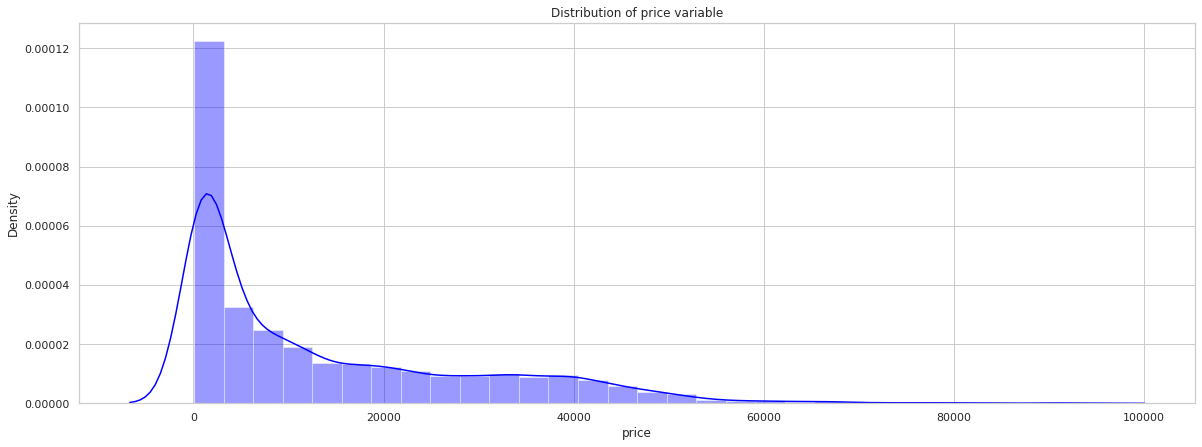

In [35]:
plt.figure(figsize=(20,7))
ax = sns.distplot(data['price'], bins=30, color='blue')
ax.set_title("Distribution of price variable")
plt.show()

/home/ikoroleva@ozon/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


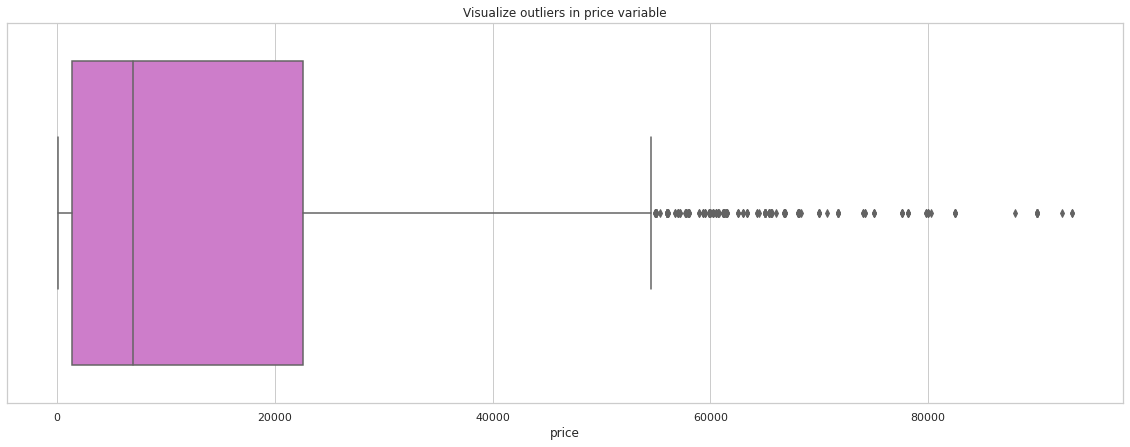

In [39]:
x = data['price']
plt.figure(figsize=(20,7))
ax = sns.boxplot(x, color = 'orchid')
ax.set_title("Visualize outliers in price variable")
plt.show()

много выбросов у цены

описательная характеристика количества доступных товаров

In [18]:
data.quantity.describe()

count    15384.000000
mean        27.859659
std        192.743352
min          1.000000
25%          2.000000
50%          5.000000
75%         12.000000
max       8563.000000
Name: quantity, dtype: float64

распределение стока - количества доступных товаров

/home/ikoroleva@ozon/.local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


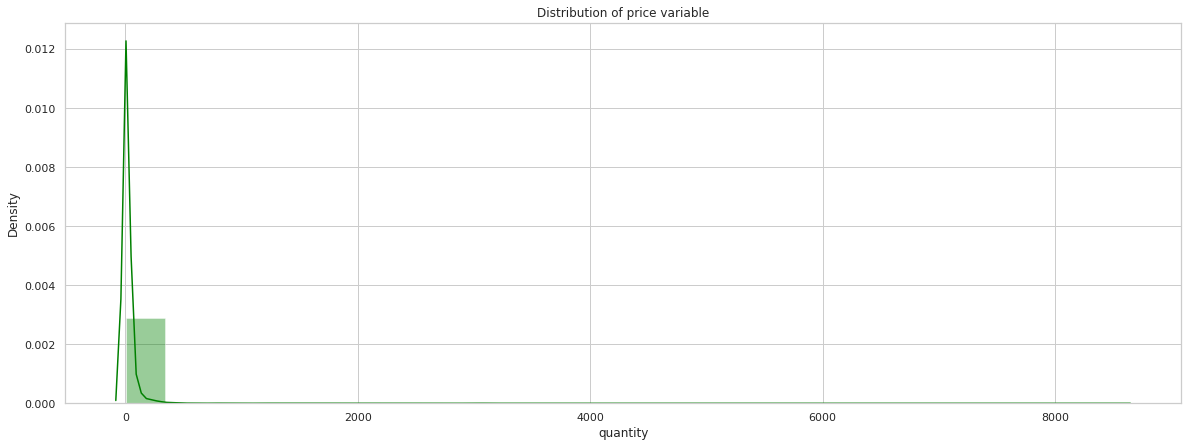

In [34]:
plt.figure(figsize=(20,7))
ax = sns.distplot(data['quantity'], bins=25, color='green')
ax.set_title("Distribution of price variable")
plt.show()

Рассмотрим подробнее скидки. Добавим столбец discount - в нем будет отображаться процент скидки. Выведем распределение скидки на товары, заметим, что самые популярные размеры скидок - это 7 и 3 процента.

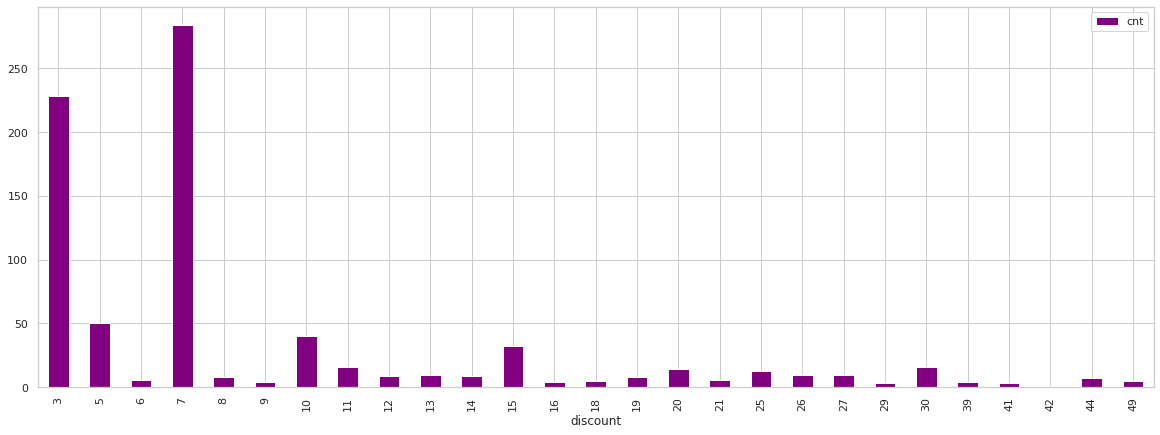

In [38]:
df = data[['oldPrice', 'price']].dropna()
df['discount'] = round(((df['price'] - df['oldPrice'])/df['oldPrice'])*(-100))
df.discount = df.discount.astype('int')
df = df[['discount', 'price']].groupby(['discount']).count()
df['cnt'] = df.price
df = df.drop(['price'], axis=1)
ax = df.plot.bar(color="purple", figsize=(20,7))

Распределение в % от всех товаров количества доступных товаров в магазине на уровне категории 1 уровня,

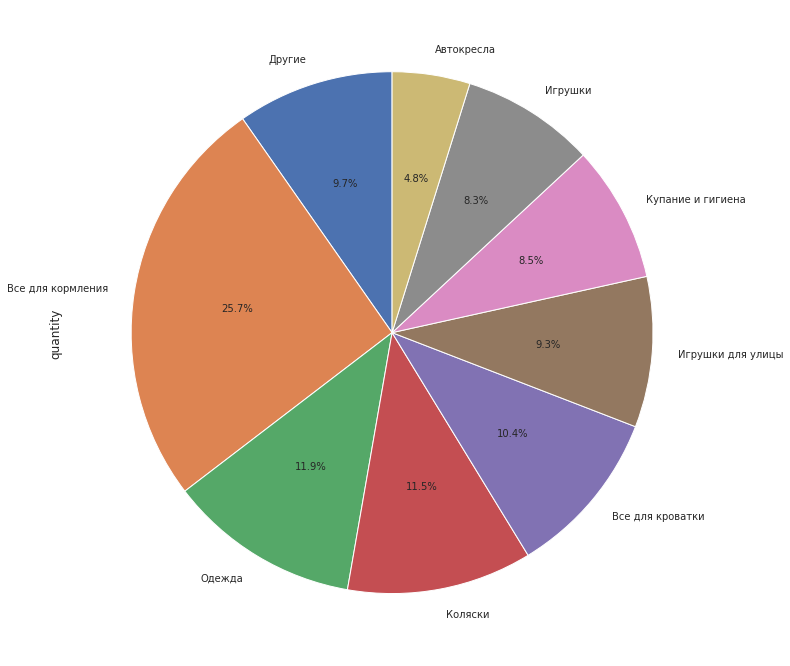

In [42]:
df = data[['category_level1', 'quantity']].groupby(['category_level1']).sum().sort_values('quantity', ascending=False).head(8)
others_sum = data[['category_level1', 'quantity']].groupby(['category_level1']).sum().sort_values('quantity', ascending=False).tail(13 - 8)['quantity'].sum()
df2 = pd.Series([others_sum], index=['quantity'])
df = pd.concat([pd.DataFrame([df2], index=['Другие']), df])
df
df.plot.pie(y='quantity',figsize=(12, 12),autopct='%1.1f%%', startangle=90, legend=False,  fontsize=10)
plt.show()

Распределение стока в рублях на уровне категории 1 уровня. Несмотря на то, что бОльшее количество товаров в категории "сток для кормления", самой дорогостоящей категорией являются коляски

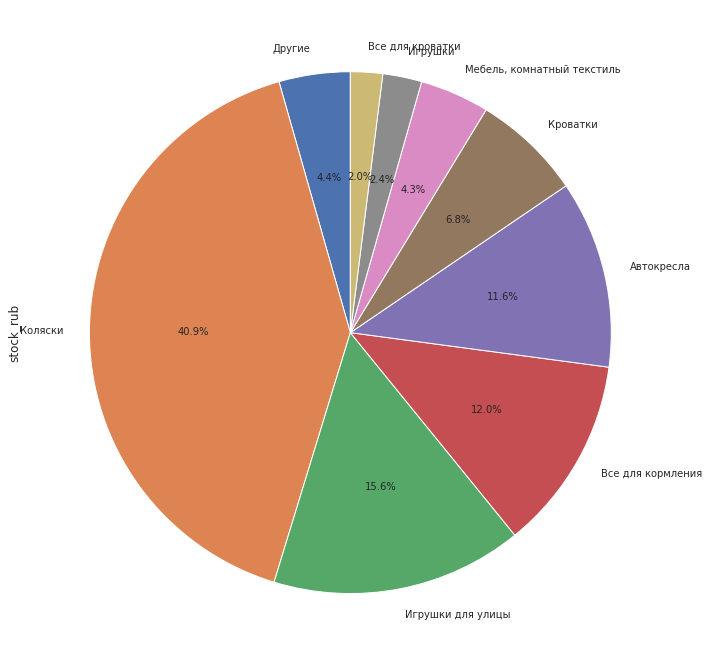

In [36]:
df = data[['category_level1', 'stock_rub']].groupby(['category_level1']).sum().sort_values('stock_rub', ascending=False).head(8)
others_sum = data[['category_level1', 'stock_rub']].groupby(['category_level1']).sum().sort_values('stock_rub', ascending=False).tail(13 - 8)['stock_rub'].sum()
df2 = pd.Series([others_sum], index=['stock_rub'])
df = pd.concat([pd.DataFrame([df2], index=['Другие']), df])
df
df.plot.pie(y='stock_rub',figsize=(12, 12),autopct='%1.1f%%', startangle=90, legend=False, fontsize=10)
plt.show()

Рассмотрим характеристики товаров более подробно. Выведем 10 самых популярных цветов товаров, белый цвет является наиболее популярным

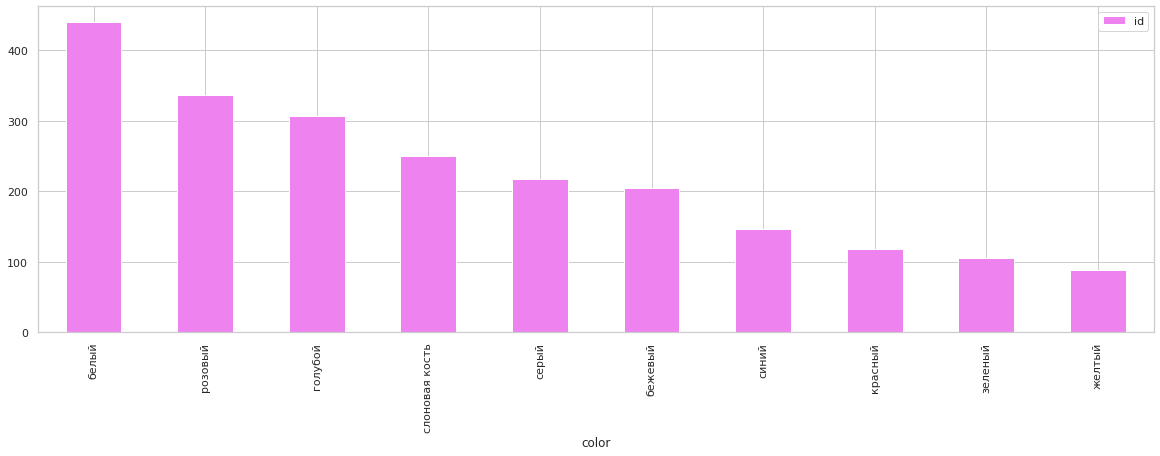

In [69]:
df = data[['color', 'id']].groupby(['color']).count().sort_values('id', ascending=False).head(11)
df = df[df.index != 'nan']
ax = df.plot.bar(color="violet", figsize=(20,6))

Мы рассмотрели атрибуты товаров, вывели различные визуализации и сделали выводы (в word file курсовой работы будет более детальное погружение). Конечным шагом будет являться загрузка данной таблицы в БД. Ниже приведена реализация того, как это можно сделать:

In [70]:
import sqlalchemy as sa

def updateType(df_para):
    dtypedict = {}  
    for i,j in zip(df_para.columns, df_para.dtypes):
        if "object" in str(j):
            dtypedict.update({i: sa.types.VARCHAR})
    return dtypedict

updatedict = updateType(data)

In [ ]:
engine = create_engine('sqlite://', echo=False)
data.to_sql(name = 'items', schema='vsekroham', con = engine,
          dtype=updatedict,
          if_exists = 'replace',
          index = False)